# 3.4.4 [SVM Guided Example & Challenge](https://courses.thinkful.com/data-201v1/project/3.4.4)

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score

#import sklearn

from sklearn import ensemble

# Challenge 
### Transform this regression problem into a binary classifier
### Clean up the features set

Can we use the ingredient and keyword list to predict the ratings from epidurious collection of recipes

* from a ratings perspective there are just over 20,000 recipes 
* average rating of 371
* 25th percentile is actually above the mean -> suggests outlier population


Fits what we know about reviews: some bad recipes have very few very low reviews

In [20]:
raw_data = pd.read_csv('unit_3_data/epi_r.csv')
test_data = raw_data

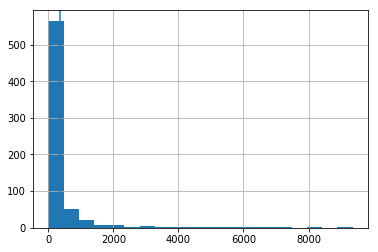

In [68]:
count_terms.review_count.hist(bins=20)
plt.axvline(x=362.88)

In [7]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [35]:
raw_data['dummy'] = 1
raw_data.groupby(['rating']).sum()['dummy']

rating
0.000    1836
1.250     164
1.875     124
2.500     532
3.125    1489
3.750    5169
4.375    8019
5.000    2719
Name: dummy, dtype: int64

## Clean Data

In [9]:
# count nulls
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [9]:
raw_data['dummy'] =1
raw_data['high_rating']=np.where(raw_data.rating >= 4.0,1.0, 0.0)
raw_data.groupby(['high_rating']).sum()['dummy']

high_rating
0.0     9314
1.0    10738
Name: dummy, dtype: int64

In [28]:
raw_data = pd.read_csv('unit_3_data/epi_r.csv')
test_data = raw_data

In [26]:
for x in test_data.columns[6:]:
    test_data[x] = np.where(test_data[x]==1.0, test_data.rating, 'Nan')


ingredients = []
average = []
count = []

for x in test_data.columns[6:]:
    ingredients.append(x)
    average.append(test_data[test_data[x] != 'Nan'][x].values.astype('float').mean())
    count.append(len(test_data[test_data[x] != 'Nan'][x]))

ingredients_mean = pd.DataFrame(data={'indredients':ingredients, 'average_rating':average, 'frequency':count})
ingredients_mean = ingredients_mean.sort_values(by='average_rating', ascending=False).reset_index(drop=True)
ingredients_mean = ingredients_mean[ingredients_mean['frequency']>273].reset_index(drop=True)


top_20 = ingredients_mean.iloc[:20,0].values
bottom_20 = ingredients_mean.iloc[-20:,0].values

raw_data = pd.read_csv('unit_3_data/epi_r.csv')

raw_data['high_rating'] = np.where(raw_data['rating']>=4.0,1,0)

In [261]:
# Model with top 20
X = raw_data[top_20]
Y = raw_data['high_rating']

rfc = ensemble.RandomForestClassifier(max_depth=4,
                                      n_estimators=6)
rfc.fit(X,Y)
cross_val_score(rfc, X, Y, cv=5)

array([0.5355273 , 0.53477936, 0.53527799, 0.53516209, 0.53554502])

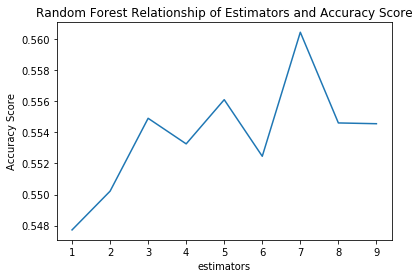

In [259]:
# Find best Random Forest parameters to be used for feature selection
X = raw_data[np.concatenate((bottom_20, top_20), axis=None)]
Y = raw_data['high_rating']


depth = []
svc_score = []
# Run Lasso
for lambd in np.arange(1, 10, 1):
    depth.append(lambd)
    rfc = ensemble.RandomForestClassifier(max_depth=4,
                                      n_estimators=lambd)
    
    rfc.fit(X, Y)
    svc_score.append(rfc.score(X, Y))
    
# Make the data pretty.
df_lasso = pd.DataFrame(data = {'lasso':svc_score,
                                'penalty': depth}
                          )
df_lasso.sort_values(by='penalty', inplace=True, ascending=True)

# Plot a line for each parameter.

plt.plot(df_lasso['penalty'], df_lasso['lasso'])
plt.xlabel('estimators')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Relationship of Estimators and Accuracy Score')
plt.show()


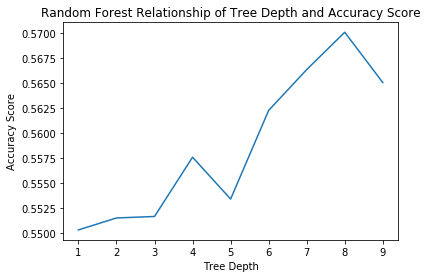

In [36]:
# Find best depth for Random Forest
X = raw_data[np.concatenate((bottom_20, top_20), axis=None)]
Y = raw_data['high_rating']


depth = []
accuracy = []
# Run Lasso
for lambd in np.arange(1, 10, 1):
    depth.append(lambd)
    rfc = ensemble.RandomForestClassifier(max_depth=lambd,
                                      n_estimators=4)
    
    rfc.fit(X, Y)
    accuracy.append(rfc.score(X, Y))
    
# Make the data pretty.
forest = pd.DataFrame(data = {'accuracy_score':accuracy,
                                'penalty': depth}
                          )
forest.sort_values(by='penalty', inplace=True, ascending=True)

# Plot a line for each parameter.

plt.plot(forest['penalty'], forest['accuracy_score'])
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Relationship of Tree Depth and Accuracy Score')
plt.show()

In [40]:
# Feature Evaluation of top and bottom 20 Using Random Forest

X = raw_data[np.concatenate((bottom_20, top_20), axis=None)]
Y = raw_data['high_rating']

rfc = ensemble.RandomForestClassifier(max_depth=4,
                                      n_estimators=6)
rfc.fit(X,Y)
#cross_val_score(rfc, X, Y, cv=5)
feature_list = pd.DataFrame(data={'importance':rfc.feature_importances_, 'features':X.columns})

feature_list = feature_list.sort_values(by='importance', ascending=False).reset_index(drop=True).iloc[0:10,1]

In [35]:
# Model with top 20 and bottome 20
X = raw_data[np.concatenate((bottom_20, top_20), axis=None)]
Y = raw_data['high_rating']
svc = SVC(C=2, gamma='auto', kernel='rbf')
svc.fit(X,Y)

cross_val_score(svc, X, Y, cv=5)

array([0.55472451, 0.55746697, 0.55771628, 0.55785536, 0.55699676])

In [48]:
# Model with top 20 and bottome 20
X = raw_data[feature_list]
Y = raw_data['high_rating']
svc = SVC(C=2, gamma='auto', kernel='rbf')
svc.fit(X,Y)

cross_val_score(svc, X, Y, cv=5)

array([0.54574919, 0.55272999, 0.55272999, 0.54837905, 0.55350461])

In [49]:
X = raw_data[feature_list]
Y = raw_data['high_rating']
svc = SVC()

penalty = []
svc_score = []
# Run SVC
for lambd in np.arange(1, 10, 1):
    penalty.append(lambd)
    svc = SVC(C=lambd, gamma='auto', kernel='rbf') 
    svc.fit(X, Y)
    svc_score.append(rfc.score(X, Y))
    
# Make the data pretty.
df_svc = pd.DataFrame(data = {'svc':svc_score,
                            'penalty': penalty}
                          )
df_svc.sort_values(by='penalty', inplace=True, ascending=True)

# Plot a line for each parameter.

plt.plot(df_svc['penalty'], df_svc['svc'])
plt.xlabel('Penalty')
plt.ylabel('Accuracy Score')
plt.title('SVC Relationship between Penalty and Accuracy Score')
plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 40 and input n_features is 10 